In [2]:
import os
os.chdir("/content/drive/MyDrive/ug-project/src")
!pwd
%load_ext autoreload
%autoreload 2

/content/drive/MyDrive/ug-project/src


In [ ]:
import numpy as np
import torchvision.transforms.v2 as v2
from datasets import FaceScrubDataset, FACESCRUB_MEAN, FACESCRUB_STD
from torch.utils.data import DataLoader

### Set hyperparameters

In [ ]:
learning_rate = 0.01
epochs = 50
batch_size = 256
output_dir = "/content/drive/MyDrive/ug-project/output/final/facescrub_blur_final"

os.makedirs(output_dir, exist_ok=True)

### Define transforms

In [ ]:
prob = 0.2
color_transforms = [v2.RandomApply([v2.ColorJitter(brightness=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(hue=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(saturation=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(contrast=0.2)], p=prob),
                    v2.RandomEqualize(p=prob),
                    v2.RandomPosterize(bits=4, p=prob),
                    v2.RandomAutocontrast(p=prob)
                    ]
transform = v2.Compose([v2.ToPILImage(),
                        v2.Resize((256, 256)),
                        v2.RandomResizedCrop(size=224, scale=(0.5, 1.0), interpolation=v2.InterpolationMode.BICUBIC),
                        v2.RandomOrder(color_transforms),
                        v2.RandomHorizontalFlip(),
                        v2.ToTensor(),
                        v2.Normalize(mean=FACESCRUB_MEAN, std=FACESCRUB_STD)
                        ])
transform_test = v2.Compose([
    v2.ToPILImage(),
    v2.Resize(224),
    v2.ToTensor(),
    v2.Normalize(mean=FACESCRUB_MEAN, std=FACESCRUB_STD)
])

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


### Load FaceScrub dataset

In [ ]:
train_dataset = FaceScrubDataset(train=True, hypertune=True, transform=transform)
print(f"Dev set size: {len(train_dataset)}")

val_dataset = FaceScrubDataset(train=False, hypertune=True, transform=transform_test)
print(f"Val set size: {len(val_dataset)}")

test_dataset = FaceScrubDataset(train=False, hypertune=False, transform=transform_test)
print(f"Test set size: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)

Dev set size: 23488
Val set size: 2936
Test set size: 2936


### Create ResNet18 model

In [ ]:
import torch
import torch.nn as nn
from model import ResNet18Sup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet18Sup(num_classes=297).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
steps = len(train_loader)
warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=optimizer, start_factor=0.01, end_factor=1.0,
                                                      total_iters=2*steps)
decay_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=(epochs - 2) * steps)
combined_scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer=optimizer,
                                                            schedulers=[warmup_scheduler, decay_scheduler],
                                                            milestones=[2*steps+1])

### Evaluate model before training

In [ ]:
!pip install kornia

In [ ]:
from utils import add_blur_with

# Initialize metrics for ploting
train_losses, train_correct = [], []
val_losses, val_correct = [], []
sigmas = []
logs = []

model.eval()
train_loss, train_corr, total_train = 0, 0, 0

with torch.no_grad():
    for _, images, labels in train_loader:
        images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        images, labels = images.to(device), labels.to(device)
        y_pred = model(images)
        loss = criterion(y_pred, labels)

        train_loss += loss.item() * images.size(0)
        predicted = torch.max(y_pred.data, 1)[1]
        train_corr += (predicted == labels).sum().item()
        total_train += labels.size(0)

avg_train_loss = train_loss / total_train
train_accuracy = (train_corr / total_train) * 100

val_loss, val_corr, total_val = 0, 0, 0

with torch.no_grad():
    for _, images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        y_val_pred = model(images)
        loss = criterion(y_val_pred, labels)

        val_loss += loss.item() * images.size(0)
        predicted = torch.max(y_val_pred, 1)[1]
        val_corr += (predicted == labels).sum().item()
        total_val += labels.size(0)

avg_val_loss = val_loss / total_val
val_accuracy = (val_corr / total_val) * 100

# Save results for plotting
train_losses.append(avg_train_loss)
train_correct.append(train_accuracy)
val_losses.append(avg_val_loss)
val_correct.append(val_accuracy)
sigmas.append(8)

# Logging the results of the epoch
log_entry = (f"Epoch 0/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
print(log_entry)
logs.append(log_entry)

Epoch 0/50, Train Loss: 5.7022, Train Acc: 0.41, Val Loss: 5.6982, Val Acc: 0.32%


### Helper function for adding blur to images

### Training loop

In [ ]:
for epoch in range(0, epochs):

    ###################### Train model #########################
    model.train()
    for _, images, labels in train_loader:

        # Apply blur sigma depending on training stage
        if epoch < 10:
            images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
            sigma = 8
        elif epoch >= 10 and epoch < 20:
            images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 1, 0])
            sigma = 4
        elif epoch >= 20 and epoch < 30:
            images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 1, 0, 0])
            sigma = 2
        elif epoch >= 30 and epoch < 40:
            images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 1, 0, 0, 0])
            sigma = 1
        elif epoch >= 40:
            images = add_blur_with(images, [0, 1, 2, 4, 8], [1, 0, 0, 0, 0])
            sigma = 0

        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        combined_scheduler.step()

    # Evaluate on training set
    model.eval()
    train_loss, train_corr, total_train = 0, 0, 0

    with torch.no_grad():
        for _, images, labels in train_loader:
            # Apply blur sigma depending on training stage
            if epoch < 10:
                images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
                sigma = 8
            elif epoch >= 10 and epoch < 20:
                images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 1, 0])
                sigma = 4
            elif epoch >= 20 and epoch < 30:
                images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 1, 0, 0])
                sigma = 2
            elif epoch >= 30 and epoch < 40:
                images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 1, 0, 0, 0])
                sigma = 1
            elif epoch >= 40:
                images = add_blur_with(images, [0, 1, 2, 4, 8], [1, 0, 0, 0, 0])
                sigma = 0
            images, labels = images.to(device), labels.to(device)

            y_pred = model(images)
            loss = criterion(y_pred, labels)

            train_loss += loss.item() * images.size(0)
            predicted = torch.max(y_pred.data, 1)[1]
            train_corr += (predicted == labels).sum().item()
            total_train += labels.size(0)

    avg_train_loss = train_loss / total_train
    train_accuracy = (train_corr / total_train) * 100

    ###################### Evaluate model ######################
    val_loss, val_corr, total_val = 0, 0, 0

    with torch.no_grad():
        for _, images, labels in val_loader:

            images, labels = images.to(device), labels.to(device)

            y_val_pred = model(images)
            loss = criterion(y_val_pred, labels)

            val_loss += loss.item() * images.size(0)
            predicted = torch.max(y_val_pred, 1)[1]
            val_corr += (predicted == labels).sum().item()
            total_val += labels.size(0)


    avg_val_loss = val_loss / total_val
    val_accuracy = (val_corr / total_val) * 100

    # Save results of current epoch
    train_losses.append(avg_train_loss)
    train_correct.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_correct.append(val_accuracy)
    sigmas.append(sigma)

    # Add epoch results to log file
    log_entry = (f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
    print(log_entry)
    logs.append(log_entry)

    # Save checkpoint every 10 epochs
    if (epoch+1) % 10 == 0:
        checkpoint_path = os.path.join(output_dir, f'model_checkpoint_epoch{epoch+1}.pth')
        checkpoint = {
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'train_accuracy': train_accuracy,
        }
        torch.save(checkpoint, checkpoint_path)

Epoch 1/50, Train Loss: 5.6207, Train Acc: 1.09, Val Loss: 5.8687, Val Acc: 0.99%
Epoch 2/50, Train Loss: 5.3860, Train Acc: 2.17, Val Loss: 6.1158, Val Acc: 1.07%
Epoch 3/50, Train Loss: 4.8661, Train Acc: 4.87, Val Loss: 5.3046, Val Acc: 3.16%
Epoch 4/50, Train Loss: 3.8547, Train Acc: 14.28, Val Loss: 4.9967, Val Acc: 3.98%
Epoch 5/50, Train Loss: 4.1361, Train Acc: 14.29, Val Loss: 5.4292, Val Acc: 3.94%
Epoch 6/50, Train Loss: 3.7148, Train Acc: 19.73, Val Loss: 8.5428, Val Acc: 0.85%
Epoch 7/50, Train Loss: 2.9057, Train Acc: 33.27, Val Loss: 7.9187, Val Acc: 2.31%
Epoch 8/50, Train Loss: 2.4501, Train Acc: 41.47, Val Loss: 7.7594, Val Acc: 1.35%
Epoch 9/50, Train Loss: 2.0469, Train Acc: 48.63, Val Loss: 6.2371, Val Acc: 3.59%
Epoch 10/50, Train Loss: 1.5418, Train Acc: 60.81, Val Loss: 7.3153, Val Acc: 3.62%
Epoch 11/50, Train Loss: 1.4912, Train Acc: 61.77, Val Loss: 2.6120, Val Acc: 40.16%
Epoch 12/50, Train Loss: 1.3308, Train Acc: 65.48, Val Loss: 2.2542, Val Acc: 47.37%
Ep

## Test model after training

In [ ]:
model.eval()
test_loss, test_correct, total_test = 0, 0, 0

with torch.no_grad():
    for _, images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        predicted = torch.max(outputs, 1)[1]
        test_correct += (predicted == labels).sum().item()
        total_test += labels.size(0)

avg_test_loss = test_loss / total_test
test_accuracy = (test_correct / total_test) * 100

# Add test results to log file
log_entry = (f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
print(log_entry)
logs.append(log_entry)

Test Loss: 0.3505, Test Accuracy: 92.97%


### Save logs to a txt file

In [ ]:
import pickle

# Data extracted from the given results
train_losses = [
    5.7022, 5.6207, 5.3860, 4.8661, 3.8547, 4.1361, 3.7148, 2.9057, 2.4501, 2.0469,
    1.5418, 1.4912, 1.3308, 1.0986, 1.0615, 0.7817, 0.8877, 0.5759, 0.6214, 0.6023,
    0.5469, 0.4704, 0.4251, 0.2975, 0.3934, 0.3585, 0.2565, 0.2549, 0.2029, 0.2148,
    0.1636, 0.1155, 0.1167, 0.0770, 0.0793, 0.0531, 0.0565, 0.0450, 0.0388, 0.0306,
    0.0243, 0.0193, 0.0156, 0.0149, 0.0136, 0.0108, 0.0106, 0.0083, 0.0096, 0.0089, 0.0095
]

train_correct = [
    0.41, 1.09, 2.17, 4.87, 14.28, 14.29, 19.73, 33.27, 41.47, 48.63,
    60.81, 61.77, 65.48, 70.79, 71.59, 78.16, 75.65, 84.10, 82.43, 82.72,
    84.05, 86.40, 87.98, 91.40, 88.68, 89.62, 92.54, 92.69, 94.14, 93.69,
    95.09, 96.62, 96.50, 97.88, 97.76, 98.61, 98.33, 98.75, 98.93, 99.22,
    99.41, 99.53, 99.63, 99.65, 99.67, 99.78, 99.70, 99.82, 99.79, 99.82, 99.79
]

val_losses = [
    5.6982, 5.8687, 6.1158, 5.3046, 4.9967, 5.4292, 8.5428, 7.9187, 7.7594, 6.2371,
    7.3153, 2.6120, 2.2542, 2.1042, 2.3555, 1.8718, 1.8420, 1.8973, 2.3248, 1.6807,
    2.2303, 0.9973, 0.9252, 0.8666, 0.8537, 0.9160, 0.8433, 0.7429, 0.7432, 0.7301,
    0.7361, 0.6042, 0.6072, 0.5471, 0.5556, 0.4847, 0.5100, 0.4805, 0.4788, 0.4614,
    0.4481, 0.4207, 0.4220, 0.4207, 0.4180, 0.4176, 0.4157, 0.4093, 0.4082, 0.4074, 0.4072
]

val_correct = [
    0.32, 0.99, 1.07, 3.16, 3.98, 3.94, 0.85, 2.31, 1.35, 3.59,
    3.62, 40.16, 47.37, 50.89, 44.85, 55.58, 56.04, 56.57, 48.05, 60.65,
    49.72, 75.21, 77.41, 79.30, 79.19, 78.34, 79.72, 82.00, 83.10, 81.85,
    83.81, 85.65, 86.22, 87.25, 87.46, 88.85, 88.32, 89.28, 89.60, 89.45,
    90.41, 90.62, 91.09, 90.94, 90.94, 91.02, 91.12, 91.26, 91.41, 91.30, 91.48
]

In [ ]:
import pickle

with open(f"{output_dir}/training_log.txt", 'w') as log_file:
    for log_entry in logs:
        log_file.write(log_entry + '\n')

metrics = {
    'train_losses': train_losses,
    'train_correct': train_correct,
    'val_losses': val_losses,
    'val_correct': val_correct
}

with open(f"{output_dir}/metrics.pkl", "wb") as metrics_file:
    pickle.dump(metrics, metrics_file)

### Plot loss

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(train_losses, color='teal', label='Avg Train Loss')
plt.plot(val_losses, color='red', label='Avg Val Loss')
plt.title(f'Loss for ResNet18 trained on FaceScrub Blurry-to-clear Sequence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'train_losses' is not defined

<Figure size 1500x600 with 0 Axes>

### Plot accuracy

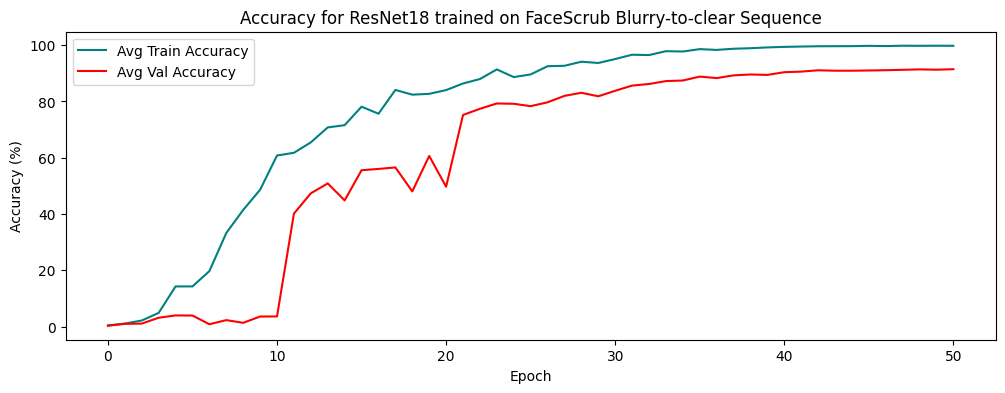

In [5]:
import matplotlib.pyplot as plt
import pickle

with open("/content/drive/MyDrive/ug-project/output/final/facescrub_blur_final/metrics.pkl", "rb") as metrics_file:
    metrics = pickle.load(metrics_file)

plt.figure(figsize=(12, 4))
plt.plot(metrics['train_correct'], color='teal', label='Avg Train Accuracy')
plt.plot(metrics['val_correct'], color='red', label='Avg Val Accuracy')
plt.title(f'Accuracy for ResNet18 trained on FaceScrub Blurry-to-clear Sequence')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()